# Introduction:

In this Notebook we simulate the paper 
<a href="https://papers.nips.cc/paper/5032-adaptive-dropout-for-training-deep-neural-networks.pdf">Adaptive dropout for training deep neural networks</a> by J Ba, et al. Forthe detailed explanation of the paper we can check the master's thesis by the same author here <a href="https://tspace.library.utoronto.ca/handle/1807/67873">Adaptive dropout for training deep neural networks - Thesis</a>. The author has used Adaptive Dropout for the purpose of using it in Autoencoders, while here I will build a classifier using the Adaptive Dropout approach in <a href="https://pytorch.org/">PyTorch</a>. 

The inspiration for the code comes from this GitHub repo: <a href="https://github.com/gngdb/adaptive-standout">gngdb/adaptive-standout</a>. The program is written to be run on Google Colab, although you can modify it to run on your own setup.

## Installation:
Since we are using Google Colab and PyTorch for our experiments we will first install the required package (PyTorch) by running the following command.

In [1]:
!pip3 install torch torchvision

## Mounting the Google Drive:

We moun the Google Drive for loading and saving our models with the following command.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Imports:
Now we make all the necessary imports required to perform and visualize our experiment.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Using GPU for our program:
Since, we want to use Google Colab's GPU we will use the following command to convert all tensors to CUDA type, as advised in this <a href="https://discuss.pytorch.org/t/solved-make-sure-that-pytorch-using-gpu-to-compute/4870"> Make Sure That Pytorch Using GPU To Compute</a>. You want to skip this part if you are working on CPU.

In [0]:
if(torch.cuda.is_available()):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

## Loading Datasets:

We load the famous and standard <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a> dataset for our program. The MNIST dataset contains 50000 (50k) training examples and 10000 (10k) examples for testing. We split the Training Set into a Training dataset and a Validation dataset. We also keep the code for loading <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR10</a> and <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion MNIST</a> dataset.

In [0]:
# Dataset Loading

# Smaller batch size causes slower loading of the entire dataset, but occupies less memory

batch_train = 512   # Smaller batch size helps in faster convergence by introducing randomness
batch_val = 1024
batch_test = 1024   

validation_set = 0.2 # This is the ratio of the training set used for validation

# Create Train and Validation Data Loaders
train_set = torchvision.datasets.MNIST(
            root = '../data/MNIST',
            train = True,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))
"""
train_set = torchvision.datasets.CIFAR10(
            root = '../data/cifar10',
            train = True,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))"""
"""
train_set = torchvision.datasets.FashionMNIST(
            root = '../data/FMNIST',
            train = True,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))"""

val_size = int(validation_set*len(train_set))
train_size = len(train_set) - val_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_train)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_val)

# Create the Test Loader
test_set = torchvision.datasets.MNIST(
            root = '../data/MNIST',
            train = False,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))
"""
test_set = torchvision.datasets.CIFAR10(
            root = '../data/cifar10',
            train = False,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))"""
"""
test_set = torchvision.datasets.FashionMNIST(
            root = '../data/FMNIST',
            train = False,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))"""

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_test)

# To be used for training
data_loaders = {}
data_loaders['Train'] = train_loader
data_loaders['Validation'] = val_loader

## Sampling Operation:
Now we perform the sampling operation for the dropout. We pass a Tensor of __Retention Probabilities__ i.e the probability with which a node will be retained, and the function returns a Tensor of the same size as Retenetion Probabilities which we call the Mask. The Mask Tensor contains **0** and __1__ values where 1 indicates a node is retained and 0 indicates a node is dropped.

In [0]:
def sample_mask(p):
    r"""Given a Tensor of probabilities 'p' this function
       will sample a mask nd return the mask (the probabilities are retention probabilities)"""
    #Random Sampling
    uniform = torch.Tensor(p.size()).uniform_(0, 1)
    #Setting Mask
    mask = uniform < p
    #Setting proper Data Type
    return mask.float()

## Standout Layer:

We define the Standout Layer here (as per Algorithm 2 in the original paper). It inherits from nn.Module class of PyTorch. The Standout Layer can easily be converted to a standard Dropout layer by setting paramaeter $\alpha=0$ and $\beta=0.5$ for a Dropout rate of $0.5$.

In [0]:
class Standout(nn.Module):
    r"""Defining the Standout Operation as per Algorithm 2"""
    def __init__(self, previousWeights, alpha, beta, nonlinearity):
        super(Standout, self).__init__()
        self.pi = previousWeights
        self.alpha = alpha
        self.beta = beta
        self.nonlinearity = nonlinearity # Sigmoid used in the original paper
    
    # Forward propagation via the layer
    def forward(self, inputs, outputs):
        self.p = self.nonlinearity(self.alpha*inputs.matmul(self.pi.t()) + self.beta)
        if(self.training):
            self.mask = sample_mask(self.p)
            return self.mask*outputs
        else:
            return self.p*outputs

## Neural Network Model:

In this section we introduce two simple CNN models for the putpose of illustration for implementing the Adaptive Dropout algorithm. In both the cases for the convolutional layers we use the following scheme:

$784$ $\rightarrow$ $24$ filters with $(5,5)$ stride and padding $=2$ $\rightarrow$ $(2,2)$ pooling with stride $=2$ $\rightarrow$ $48$ filters with $(5,5)$ stride and padding $=2$ $\rightarrow$ $(2,2)$ pooling with stride $=2$ $\rightarrow$ $64$ filters with $(5,5)$ stride and padding $=2$ $\rightarrow$ $(2,2)$ pooling with stride $=2$ $\rightarrow$ Flatten to $576$ nodes.

1. In the first case we use a CNN with only a single fully with $256$ nodes connected layer at the end, the Adaptive Dropout will be applied to this fully connected layer.

2. In the second case we use a CNN with two fully connected layer, each with $256$ nodes, at the end, the Adaptive Dropout will be applied to this two fully connected layers.

In [0]:
class Neural_Net(nn.Module):

    def __init__(self):
        super(Neural_Net, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1,24,5, padding = 2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(24,48,5, padding = 2)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv3 = nn.Conv2d(48,64,5, padding = 2)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(576,256)
        self.std1 = Standout(self.fc1.weight, 0.5, 0.5, nn.Sigmoid()) # Standout Layer 1
        self.fc2 = nn.Linear(256, 256)
        self.std2 = Standout(self.fc2.weight, 0.5, 0.5, nn.Sigmoid()) # Standout Layer 2
        self.final = nn.Linear(256,10)

    def forward(self, x):
        # Convolutional Layers Forward Propagation
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 576)
        
        # Fully Connected Layers Forward Propagation
        inputs1 = x.clone().detach()
        x = F.relu(self.fc1(x))
        inputs2 = x.clone().detach()  # NOTE: We have to use the inputs of previous layer for Standout
        x = self.std1(inputs1,x)
        #x = F.relu(self.fc2(x))       # Comment out if you want to use single FC layer
        #x = self.std2(inputs2, x)     # Comment out if you want to use single FC layer
        x = self.final(x)
        return x

## Training:

Now we train the Neural Network with the loss function as the Binary Cross Entropy Loss, using a very simple (but unflexible) scheme, we use SGD with Momentum for the first 50 epochs and then the Adam optimizer for the next 50 epochs for a total of 100 epochs. The training algorithm shows the Training Loss, Training Accuracy, Validation Loss and Validation Accuracy for each epochs. It returns a list with average loss and accuracy for Training and Validation phases for the purpose of plotting it.

**Hyperparameters** - You can tune the Hyperparamaters at the begining and also define variables to do so (I have excluded it since I have not fine tuned the model).

In [62]:
# Initializing the Neural Net and all the Hyperparamters
net = Neural_Net()
if(torch.cuda.is_available()):
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net.parameters(), lr = 0.01, momentum= 0.9)
optimizer2 = optim.Adam(net.parameters(), lr = 0.001)
epochs1 = 5
epochs2 = 5

# Lists required for plotting the final results
lossT = []
lossCV = []
accCV = []
accT = []

# Function to train the model
def train(epochs1, epochs2, data_loaders):
    # Running with the SGD with momentum optimizer
    for i in range(epochs1):
        print('Epoch: ' + str(i+1))
        for phase in ['Train', 'Validation']:
            
            #Total predictions and Correct predictions set to 0
            total = 0
            correct = 0

            #Running loss  set to 0
            running_loss = 0.0

            # Number of minibatches 
            # NOTE: Even though the batch size might not be uniform,
            # we approximate it as all batches are of equal size
            k = len(data_loaders[phase])
            
            if phase == 'Train':
                net.train(True)  # Set model to training mode
            else:
                net.train(False) # Set model to validation mode

            # Iterate through the batches             
            for data in data_loaders[phase]:
                images,labels = data
                if(torch.cuda.is_available()):
                    labels = labels.long().cuda()
                    images = images.cuda()
                else:
                    labels = labels.long()
                outputs = net.forward(images)

                loss = criterion(outputs, labels)
                optimizer1.zero_grad()

                # Backprop + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    # Update the weights
                    optimizer1.step()
                running_loss += loss.item()

                #Check predictions
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)                  # length of each batch added
                correct += (predicted == labels).sum().item()

        
            epoch_loss = running_loss/k
            epoch_acc = correct/total
            if(phase == 'Train'):
                lossT.append(epoch_loss)
                accT.append(epoch_acc)
            elif(phase == 'Validation'):
                lossCV.append(epoch_loss)
                accCV.append(epoch_acc)

            # Print for showing  loss and accuracy                          
            print('Loss for ' + phase + ' is ' + str(epoch_loss))
            print('Accuracy for ' + phase + ' is ' + str(epoch_acc)) 
        print()

    # Running with the Adam optimizer
    for i in range(epochs2):
        print('Epoch: ' + str(i+1+epochs1))
        for phase in ['Train', 'Validation']:
            
            #Total predictions and Correct predictions set to 0
            total = 0
            correct = 0

            #Running loss  set to 0
            running_loss = 0.0

            # Number of minibatches 
            # NOTE: Even though the batch size might not be uniform,
            # we approximate it as all batches are of equal size
            k = len(data_loaders[phase])
            
            if phase == 'Train':
                net.train(True)  # Set model to training mode
            else:
                net.train(False) # Set model to validation mode

            # Iterate through the batches             
            for data in data_loaders[phase]:
                images,labels = data
                if(torch.cuda.is_available()):
                    labels = labels.long().cuda()
                    images = images.cuda()
                else:
                    labels = labels.long()
                outputs = net.forward(images)

                loss = criterion(outputs, labels)
                optimizer2.zero_grad()

                # Backprop + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    # Update the weights
                    optimizer2.step()
                running_loss += loss.item()

                #Check predictions
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)                  # length of each batch added
                correct += (predicted == labels).sum().item()

        
            epoch_loss = running_loss/k
            epoch_acc = correct/total
            if(phase == 'Train'):
                lossT.append(epoch_loss)
                accT.append(epoch_acc)
            elif(phase == 'Validation'):
                lossCV.append(epoch_loss)
                accCV.append(epoch_acc)

            # Print for showing loss and accuracy                 
            print('Loss for ' + phase + ' is ' + str(epoch_loss))
            print('Accuracy for ' + phase + ' is ' + str(epoch_acc)) 
        print()
    return lossT, lossCV, accT, accCV

train(epochs1, epochs2, data_loaders)

Epoch: 1
Loss for Train is 2.2858726344210036
Accuracy for Train is 0.19583333333333333
Loss for Validation is 2.235354006290436
Accuracy for Validation is 0.45775

Epoch: 2
Loss for Train is 1.1602210129829162
Accuracy for Train is 0.6634166666666667
Loss for Validation is 0.343149575094382
Accuracy for Validation is 0.8980833333333333

Epoch: 3
Loss for Train is 0.25987013128209624
Accuracy for Train is 0.9179375
Loss for Validation is 0.17378280932704607
Accuracy for Validation is 0.94475

Epoch: 4
Loss for Train is 0.16732515965370423
Accuracy for Train is 0.9470833333333334
Loss for Validation is 0.1453044538696607
Accuracy for Validation is 0.953

Epoch: 5
Loss for Train is 0.12465016290228417
Accuracy for Train is 0.9608958333333333
Loss for Validation is 0.09871997249623139
Accuracy for Validation is 0.96825

Epoch: 6
Loss for Train is 0.18615993373888604
Accuracy for Train is 0.9458541666666667
Loss for Validation is 0.0904368522266547
Accuracy for Validation is 0.9715

Epoch:

([2.2858726344210036,
  1.1602210129829162,
  0.25987013128209624,
  0.16732515965370423,
  0.12465016290228417,
  0.18615993373888604,
  0.08544333382172788,
  0.06562445110621605,
  0.05375501727487179,
  0.04443622858045583],
 [2.235354006290436,
  0.343149575094382,
  0.17378280932704607,
  0.1453044538696607,
  0.09871997249623139,
  0.0904368522266547,
  0.07910643952588241,
  0.058179082038501896,
  0.048958648617068924,
  0.042168361290047564],
 [0.19583333333333333,
  0.6634166666666667,
  0.9179375,
  0.9470833333333334,
  0.9608958333333333,
  0.9458541666666667,
  0.9730833333333333,
  0.9794166666666667,
  0.9828125,
  0.9857916666666666],
 [0.45775,
  0.8980833333333333,
  0.94475,
  0.953,
  0.96825,
  0.9715,
  0.9746666666666667,
  0.9814166666666667,
  0.9853333333333333,
  0.9871666666666666])

## Plotting:

We now plot the loss and accuracy of our training, on the Training and Validation set.


In [0]:
%matplotlib inline

Text(0, 0.5, 'Epochs')

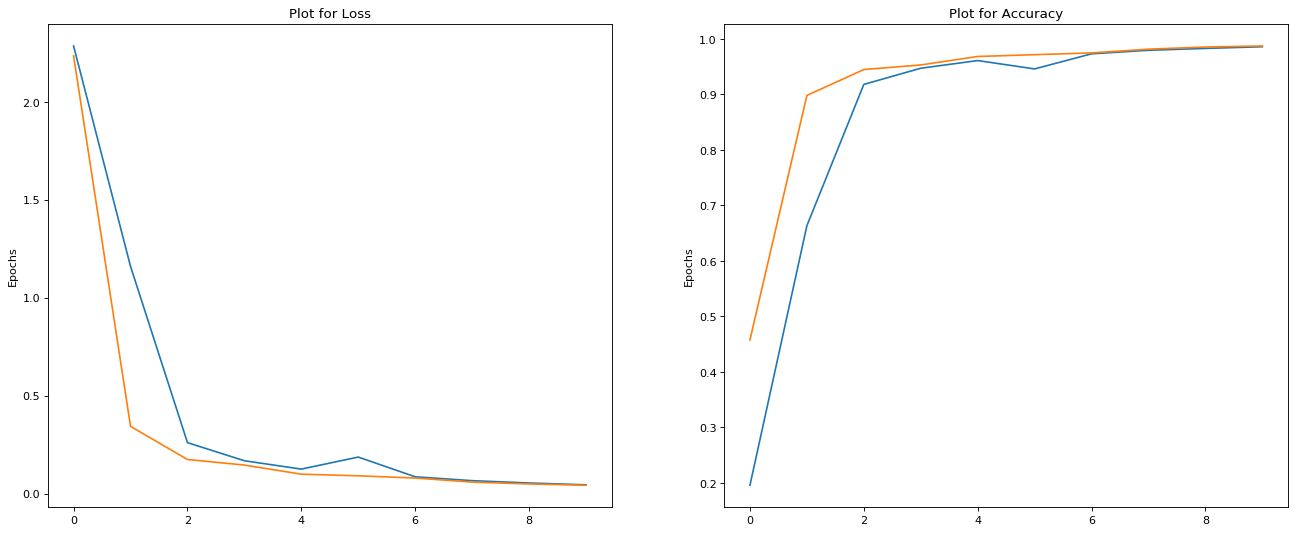

In [64]:
epochs = list(range(epochs1+epochs2))
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, lossT, epochs, lossCV)
plt.title('Plot for Loss')
plt.ylabel('Loss')
plt.ylabel('Epochs')

#Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accT, epochs, accCV)
plt.title('Plot for Accuracy')
plt.ylabel('Accuracy')
plt.ylabel('Epochs')



## Saving the model:

We save the PyTorch model for future use and for testing it on the Test set.

In [0]:
save_name = 'ada_drop_classifier.pt'
path = F"/content/gdrive/My Drive/Adaptive Dropout/{save_name}" 
torch.save(net.state_dict(), path)

## Loading the model:

We load the model for inference.

In [66]:
save_name = 'ada_drop_classifier.pt'
path = F"/content/gdrive/My Drive/Adaptive Dropout/{save_name}"
net = Neural_Net()
net.load_state_dict(torch.load(path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Perform Inference on the Test set:

We now perform inference on the Test Set.

In [68]:
net.eval()
def test(test_loader):
    #Total predictions and Correct predictions set to 0
    total=0
    correct=0
    # Iterate through the batches             
    for data in test_loader:
        images, labels = data
        if(torch.cuda.is_available()):
          labels = labels.long().cuda()
          images = images.cuda()
        else:
          labels = labels.long()
        outputs = net.forward(images)

        #Check predictions
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)                  # length of each batch added
        correct += (predicted == labels).sum().item()
    print("Accuracy for Test Set is " + str(correct/total))

test(test_loader)

Accuracy for Test Set is 0.9888
